In [1]:
import os

print("The Jupyter Notebook is currently running from:")
print(os.getcwd())
print("-" * 30)

The Jupyter Notebook is currently running from:
E:\ANN
------------------------------


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
# --- Data Loading and Preprocessing ---
DATA_DIR = '.' # Same folder
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
LABELS_PATH = os.path.join(DATA_DIR, 'labels.csv')

df_labels = pd.read_csv(LABELS_PATH) #loading labels

BREEDS = sorted(df_labels['breed'].unique()) #soring the list of breed
NUM_CLASSES = len(BREEDS)
print(f"Total number of dog breeds: {NUM_CLASSES}")

label_map = dict(zip(df_labels['id'], df_labels['breed'])) # Dictionary by Mapping image paths: ID -> BREED

file_paths_and_labels = [] # list of (filepath, breed_index) tuples
for file_id, breed_name in label_map.items():
    # Construct filename using the ID and .jpg extension
    file_path = os.path.join(TRAIN_DIR, f"{file_id}.jpg")
    breed_index = BREEDS.index(breed_name)
    file_paths_and_labels.append((file_path, breed_index))

Total number of dog breeds: 120


In [4]:
df_files = pd.DataFrame(file_paths_and_labels, columns=['filepath', 'label']) #for splitting

df_train, df_val = train_test_split(
    df_files,
    test_size=0.2, # 80% train, 20% validation
    stratify=df_files['label'],
    random_state=42
) #straisfy to equally distribute breeds into train and val

print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")

IMG_SIZE = 224 
BATCH_SIZE = 32

Training samples: 8177
Validation samples: 2045


In [5]:
# Replicate the ResNet V2 definition from your create_hybrid_model function:
import tensorflow.keras as keras

resnet_model_base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

print(f"Original ResNet Output Shape (H, W, C): {resnet_model_base.output_shape}")

Original ResNet Output Shape (H, W, C): (None, 7, 7, 2048)


In [6]:
#creating functions
def load_and_preprocess(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) #rescaling to [1,1] as per ResNetV2
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, label

# foe efficient loading
def make_dataset(df):
    filepaths = df['filepath'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=4096).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = make_dataset(df_train)
val_ds = make_dataset(df_val)

In [7]:
# Vision Transformer Block (Encoder)
class TransformerBlock(layers.Layer):
    # Using 'embed_dim' and 'ff_dim' to match your provided snippet's __init__ 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # FIX: Reintroduced 'training=None'. This makes the argument optional,
    # satisfying the Functional API call, and it is passed to internal dropouts.
    def call(self, inputs, training=None):
        # Multi-Head Attention
        attn_output = self.att(inputs, inputs) 
        # Pass the training status explicitly to internal dropout layers
        attn_output = self.dropout1(attn_output, training=training)
        
        # Add & Norm (Residual connection 1 + LayerNorm)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-Forward Network
        ffn_output = self.ffn(out1)
        # Pass the training status explicitly to internal dropout layers
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Add & Norm (Residual connection 2 + LayerNorm)
        return self.layernorm2(out1 + ffn_output)

In [8]:
# Positional Embedding Layer
class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embedding = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        return inputs + self.position_embedding(positions)

In [9]:
# Hybrid Model construction
# Setting hyperparameters for Vision Transformers
NUM_HEADS = 4         # Number of attention heads
TRANSFORMER_LAYERS = 3 # Number of Transformer blocks
PROJECTION_DIM = 192  # Output dimension of the CNN features as input to Transformer, i.e. projection dimensions
FFN_DIM = 512         # Hidden dimensions in the Feed-Forward Network
NUM_CLASSES=120        #Number of target classes. 120 breeds

In [10]:
class ClassTokenInsertion(layers.Layer):#creation and concat of CLS token
    def __init__(self, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim

    def call(self, inputs): # inputs shape: (batch_size, H*W, C)
        batch_size = tf.shape(inputs)[0] #batch size from tensor
        
        # Creating the symbolic class token tensor (Batch, 1, C)
        class_token = tf.zeros((batch_size, 1, self.projection_dim))
        
        # Concatenate: (Batch, 1 + H*W, C)
        return tf.concat([class_token, inputs], axis=1)

# --- Model Function ---
def create_hybrid_model():
    # First, CNN head (feature extractor)
    resnet_model = keras.applications.ResNet50V2(
        include_top=False, 
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    # Freeze CNN weights
    resnet_model.trainable = False 
    cnn_output = resnet_model.output

    # Then, patching and embedding by reshaping CNN features for ViT
    # Reduce features to fit into model projection dimension
    x = layers.Conv2D(PROJECTION_DIM, kernel_size=1, padding="valid")(cnn_output) 
    
    # Calculate dimensions
    _, h, w, c = x.shape
    
    # Reshape the 2D feature map into a 1D sequence of "patches"
    x = layers.Reshape((h * w, c))(x) 
    
    # Sequence length including the CLS token
    SEQUENCE_LENGTH = h * w + 1
    
    # Create and prepend the CLS token
    x = ClassTokenInsertion(PROJECTION_DIM)(x)
    
    # Add positional embeddings
    x = PositionEmbedding(SEQUENCE_LENGTH, PROJECTION_DIM)(x)
    x = layers.Dropout(0.3)(x)

    # Then, ViT Body (transformer encoder blocks)
    for _ in range(TRANSFORMER_LAYERS):
        # The arguments passed here are (embed_dim, num_heads, ff_dim)
        # This call is now fixed as TransformerBlock.call no longer requires 'training'
        x = TransformerBlock(PROJECTION_DIM, NUM_HEADS, FFN_DIM)(x)

    # Classification Head
    # Adding a global average pooling for robustness (using all tokens)
    representation = layers.GlobalAveragePooling1D()(x) 
    
    # Final MLP head
    logits = layers.Dense(NUM_CLASSES, activation='softmax')(representation)

    # Creating the model
    model = keras.Model(inputs=resnet_model.input, outputs=logits)
    return model

# Example usage (will now run without the KerasTensor error)
try:
    model = create_hybrid_model()
    print("Model successfully created.")
except Exception as e:
    print(f"An error occurred during model creation: {e}")


Model successfully created.


In [11]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 56, 56, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 56, 56, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 58, 58, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 26,362,168 (100.56 MB)

 Trainable params: 2,797,368 (10.67 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [12]:
# Use Adam optimizer, which is efficient for GPUs
optimizer = keras.optimizers.Adam(learning_rate=5e-5)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- Add Early Stopping Callback ---
early_stopper = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=4,                
    restore_best_weights=True,  # Crucial: Keeps the weights from the best-performing epoch
    mode='min'                  # Look for minimum loss
)

In [14]:
checkpoint_filepath = 'best_model_weights.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Save the entire model
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [15]:
# Training Epochs
EPOCHS = 60

print("\nStarting Training with Early Stopping...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopper, model_checkpoint_callback] # Pass both callbacks here
)


Starting Training with Early Stopping...
Epoch 1/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 215s 799ms/step - accuracy: 0.3473 - loss: 3.1450 - val_accuracy: 0.5897 - val_loss: 1.8188
Epoch 2/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 205s 796ms/step - accuracy: 0.6463 - loss: 1.6510 - val_accuracy: 0.6729 - val_loss: 1.3663
Epoch 3/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 202s 785ms/step - accuracy: 0.7131 - loss: 1.2640 - val_accuracy: 0.6973 - val_loss: 1.1789
Epoch 4/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 782ms/step - accuracy: 0.7482 - loss: 1.0679 - val_accuracy: 0.7061 - val_loss: 1.0908
Epoch 5/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 201s 784ms/step - accuracy: 0.7690 - loss: 0.9237 - val_accuracy: 0.7134 - val_loss: 1.0369
Epoch 6/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 208s 808ms/step - accuracy: 0.7894 - loss: 0.8307 - val_accuracy: 0.7232 - val_loss: 1.0018
Epoch 7/60
256/256 ━━━━━━━━━━━━━━━━━━━━ 200s 777ms/step - accuracy: 0.8070 - loss: 0.7500 - val_accuracy: 0.7242 - val_loss: 0.9933
Epoch 8/60
256/256 ━━━━━━━━━━━━━━━

In [22]:
results = model.evaluate(train_ds, verbose=1)

print("\n--- Evaluation Results ---")
print(f"Training Loss: {results[0]:.4f}")
print(f"Training Accuracy: {results[1]:.4f}")

256/256 ━━━━━━━━━━━━━━━━━━━━ 145s 562ms/step - accuracy: 0.8876 - loss: 0.4419

--- Evaluation Results ---
Training Loss: 0.4419
Training Accuracy: 0.8876


In [17]:
results = model.evaluate(val_ds, verbose=1)

print("\n--- Evaluation Results ---")
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 549ms/step - accuracy: 0.7340 - loss: 0.9464

--- Evaluation Results ---
Validation Loss: 0.9464
Validation Accuracy: 0.7340


In [19]:
import pickle
import os

# Define the paths for the saved files
SAVE_DIR = '.' # Save in the current directory
MODEL_FILENAME = 'dog_breed_hybrid_model.keras'
BREEDS_FILENAME = 'dog_breeds.pkl'

# 1. Save the Model
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)
# Keras automatically handles saving custom layers (TransformerBlock, PositionEmbedding)
# when saving in the .keras format.
model.save(MODEL_PATH) 
print(f"Model saved successfully to: {MODEL_PATH}")

# 2. Save the list of breeds (classes)
# The BREEDS list (defined in your preprocessing cell) is vital for decoding the model's prediction index.
BREEDS_PATH = os.path.join(SAVE_DIR, BREEDS_FILENAME)
with open(BREEDS_PATH, 'wb') as f:
    # Assuming 'BREEDS' is the variable holding your sorted list of dog breed strings
    pickle.dump(BREEDS, f) 
print(f"Breeds list saved successfully to: {BREEDS_PATH}")

Model saved successfully to: .\dog_breed_hybrid_model.keras
Breeds list saved successfully to: .\dog_breeds.pkl


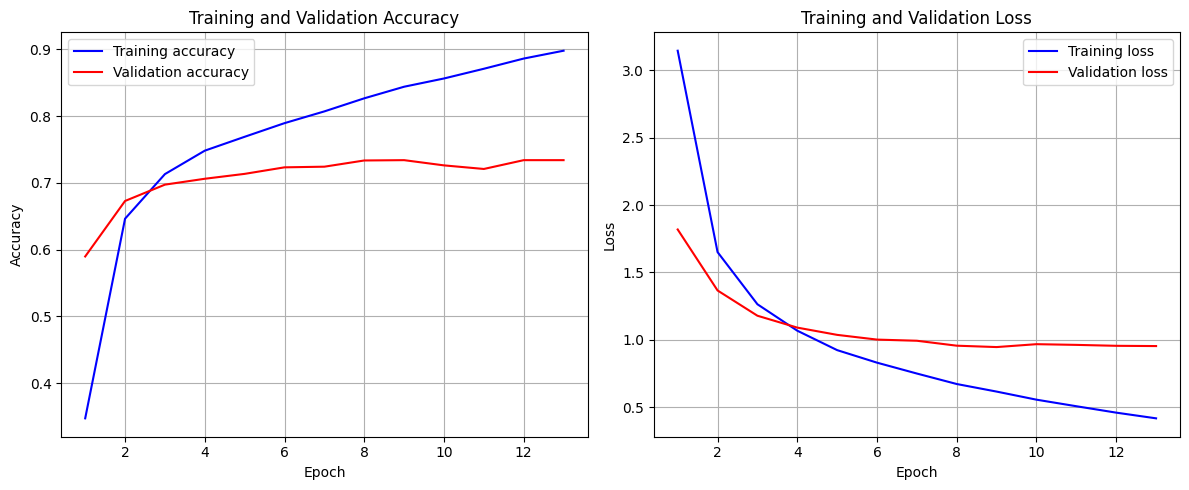

In [20]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    # Get the data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # --- Plot Accuracy ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- Plot Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
# Execute the function after training is complete
plot_learning_curves(history)